#Bank Churn Prediction

###Background and Context

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

###Objective

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

###Data Dictionary

- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary 
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
- Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )



#Import Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras

In [4]:
from sklearn import model_selection, metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow.keras import losses, optimizers, Sequential, backend, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras import callbacks

from imblearn.over_sampling import SMOTE

import random
import time

#Import Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/Python Course/Churn.csv')

In [7]:
df = data.copy()

# Data Overview

In [8]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


- data imported succesfully

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- Our data has 10,000 rows and 14 columns (13 independent feature columns and 1 target variable column)
- There are 3 object type variable columns and 11 numerical columns of which 2 contain float type variables while the other 9 are integets
- Each column shows a count of 10,000 non-null values so it doesn't appear we have any missing data.

In [10]:
df.duplicated().sum()

0

- There are not any duplicated entries in our dataset

In [11]:
df.describe().T.applymap(lambda x: f"{x:0.2f}")

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.00,5000.50,2886.90,1.00,2500.75,5000.50,7500.25,10000.00
CustomerId,10000.00,15690940.57,71936.19,15565701.00,15628528.25,15690738.00,15753233.75,15815690.00
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48


- Mean age is approx. 39, while max age will probably appear as outlier, being 92 is quite old compared to the average customer age.
- Average tenure, or years with the bank, is 5 years with a max of 10. So no customers in the dataset have been with the bank longer than 10 years.
- Mean balance is somewhat high at approx. 76,500 but the range is very wide as it spans from a 0 balance to as high as over 250,000. This means that we are likely to see outliers on both ends of the spectrum.
- Average number of bank products owned by customers is 1.5 while max is 4 products.
- Estimated salary shows over 100,000 for the average but interestingly a minimum estimated salary of 11.58 which seems very unlikely to be a salary but again it is only an estimate and we are not sure how they are reaching that estimate. With cutomers as young as 18 and some customers balance being 0, I guess it could be possible for an algorithm of some kind to estimate such a low salary. This will likely be an outlier being so far from the average. 

In [12]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

- We can see from this that both 'RowNumber' and 'CustomerID' are simply identifiers so we can drop these as they will not be necessary for our model.

- 'EstimatedSalary' only has 2 customers with the same estimated salary out of our 10,000 customer dataset. This confirms what we suspected with salary being estimated down to the penny.

In [13]:
df.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True)

'Surname'  ia not distinguishing factor for determining if someone will leave the bank or not for our model, therefore we will drop it as well.

In [14]:
df.drop(['Surname'], axis=1, inplace=True)

In [15]:
df.head(1)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


- 'RowNumber', 'CustomerId', and 'Surname' have been successfully dropped

In [16]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

- 'Exited' is our target variable, which the value counts show as being unbalanced.
- Over twice as many customers in the dataset are still with the bank, as opposed to those who have left the bank.

#EDA

###Univariate Analysis

In [17]:
# function for boxplot and a histogram on combined scale

def hist_box(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    Data: df
    feature: df column
    figsize: default(12,7)
    kde: show density curve (defualt False)
    bins: bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,
        sharex=True,
        gridspec_kw={'height_ratios': (0.25, 0.75)},
        figsize=figsize
    )
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color='orange'
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette='winter'
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2 
    )
    ax_hist2.axvline(
        data[feature].mean(), color='green', linestyle='--'
    )
    ax_hist2.axvline(
        data[feature].median(), color='black', linestyle='-'
    )

###Credit Score

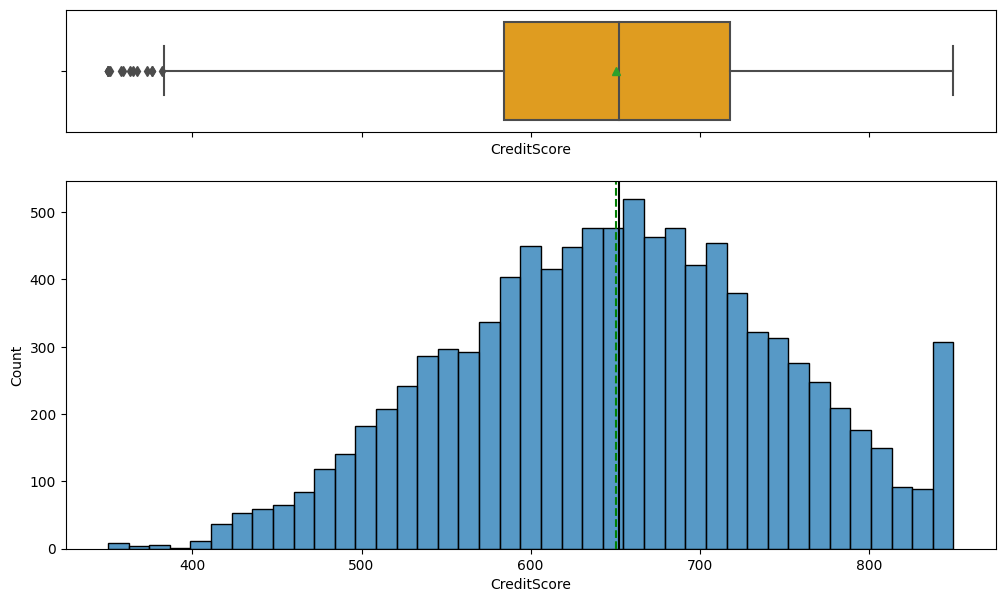

In [18]:
hist_box(df, 'CreditScore')

- Credit score has a slight left skew due to outliers on the low side below a 400 credit score.
- The count of customers seems to steadily decline past s mid 600 credit score, but then there is a high spike of over 300 customers at the max value of an 850 credit score.

###Age

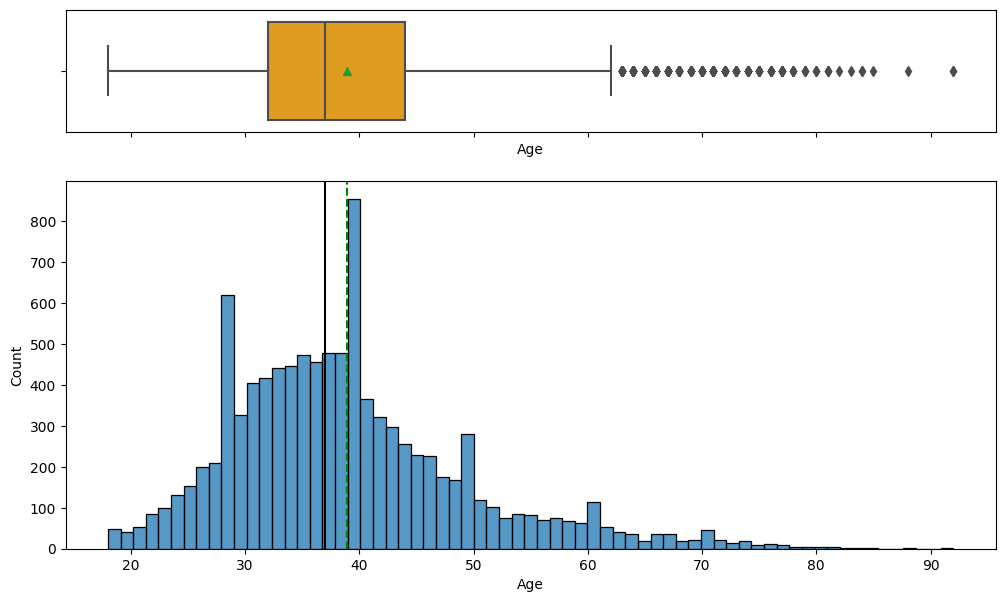

In [19]:
hist_box(df, 'Age')

- Age has a significant right skew with any age over 60 being considered an outlier as far as age goes.
- We can see here that the max age of 92 is indeed an extreme outlier.

###Tenure

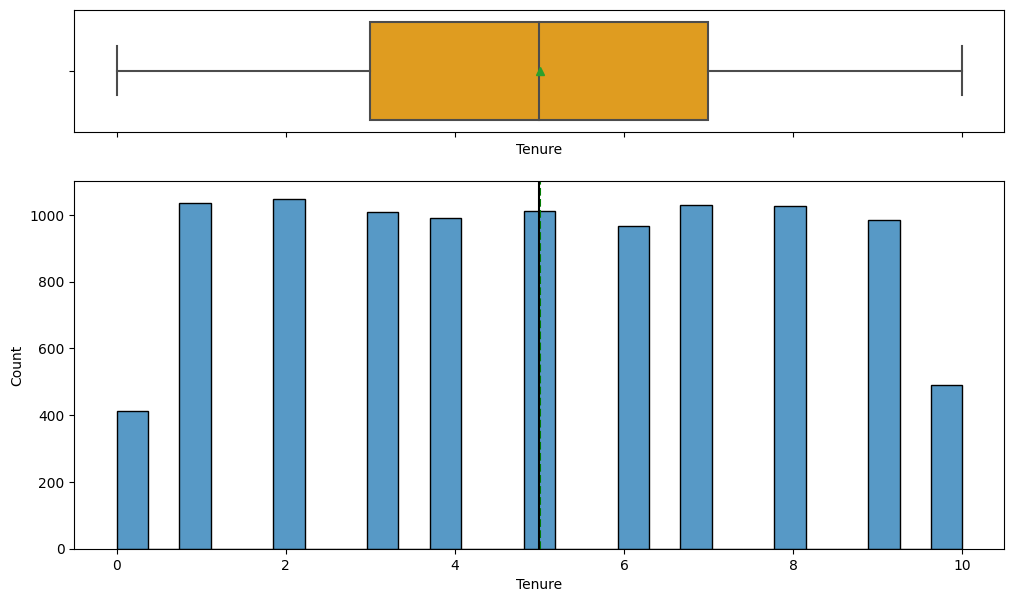

In [20]:
hist_box(df, 'Tenure')

- Tenure has a somewhat even distribution across the years with a smaller number at the min. and max compared to the other tenure lengths in years.
- The mean and median both sit in the dead center at a 5 year tenure length.

###Number of Products

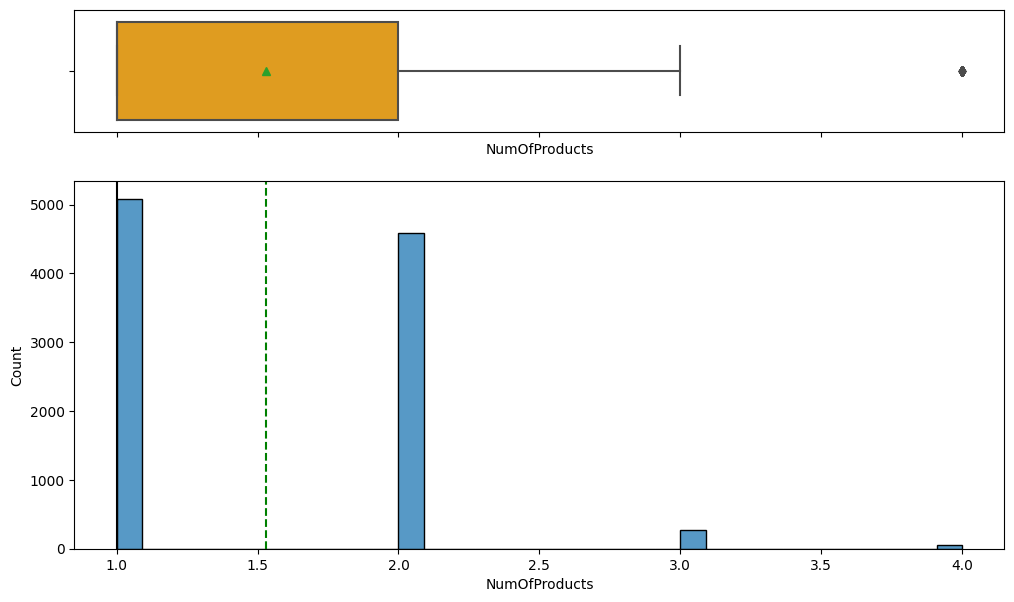

In [21]:
hist_box(df, 'NumOfProducts')

- It would seem the largest portion of customers only have 1 bank product. Two products is the next highest category with almost as many customers as those with 1 product.
- Only a samll number of customers have 3 or 4 bank products, with 4 products being considered an outlier.

###Balance

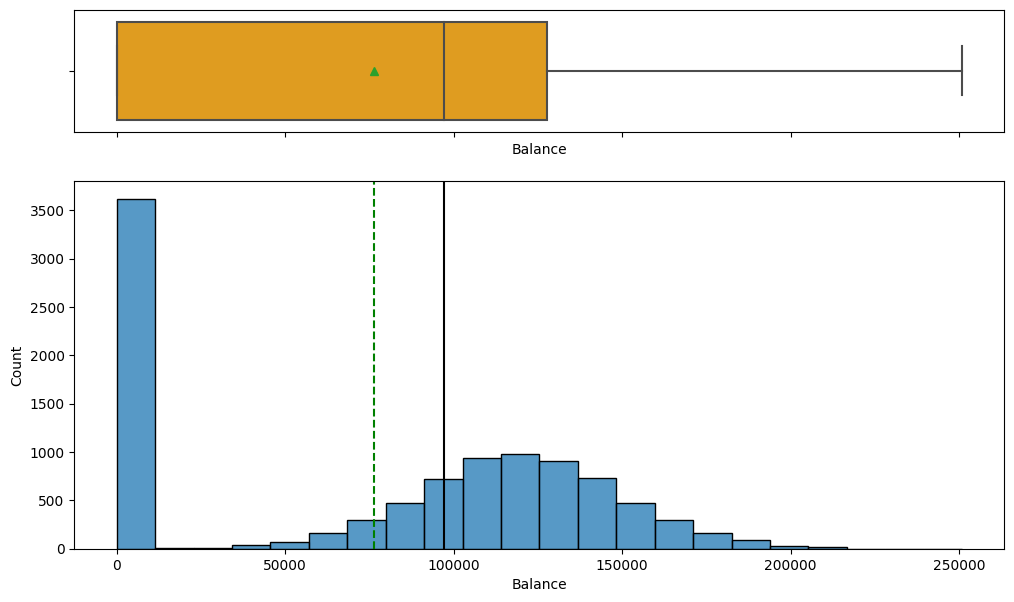

In [22]:
hist_box(df, 'Balance')

- A little over a third of customers have a 0 balance which is quite surpring given that the average balance was around 76,500.
- Surprisingly no balance amounts are considered outliers, even with a range of 0 to 250,000.

### Has Credit Card

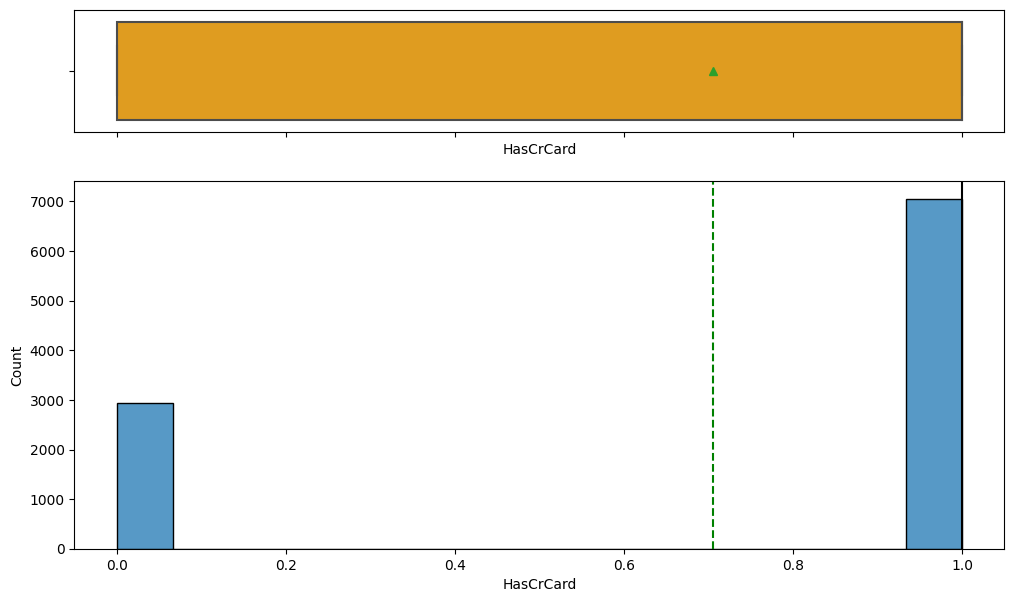

In [23]:
hist_box(df, 'HasCrCard')

- A little over two thirds of customers have a credit card with the bank.

### Estimated Salary

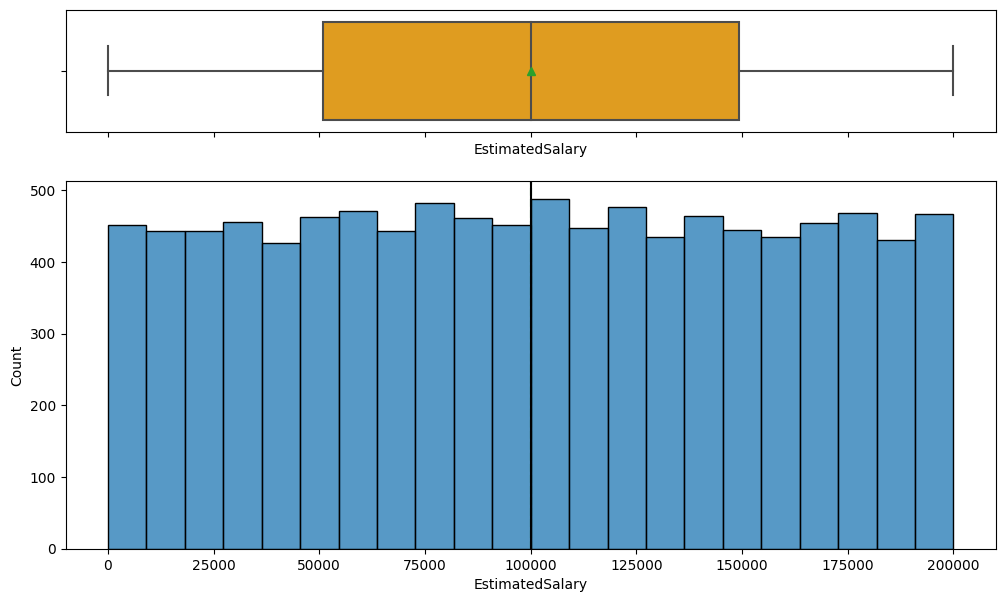

In [24]:
hist_box(df, 'EstimatedSalary')

- Estimated salary has a pretty even distribution across the whole estimated salary range.
- There are no outliers despite an estimated salary range extending from as low as 11.85 up to nearly 200,000.

###Is Active Member

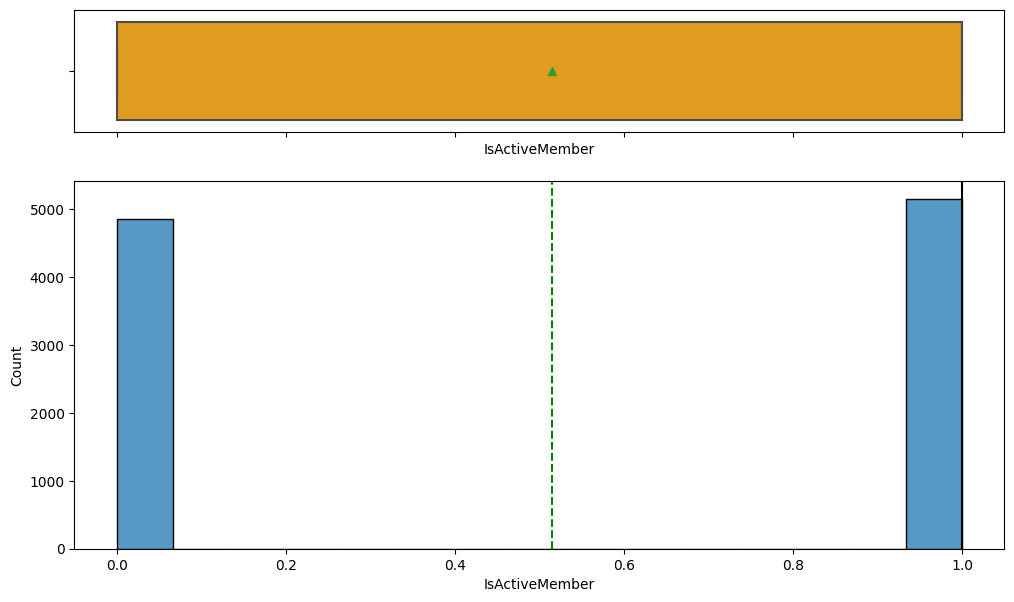

In [25]:
hist_box(df, 'IsActiveMember')

- Only slightly over half of the customers are considered active members. This might be why the bank is wanting to try and predict whether or not a customer will leave, as having this many inactive customers can not be good for business.

###Exited

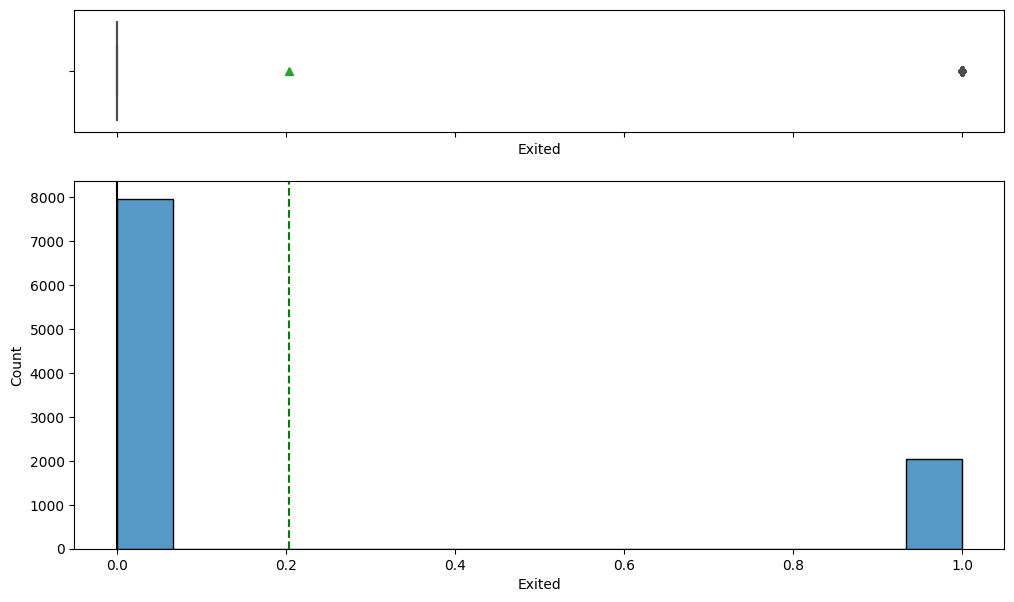

In [26]:
hist_box(df, 'Exited')

- Although there is a high number of inactive members, less than a fourth of customers in the dataset actually left the bank.
- This result tells us that the target variable in our dataset is imbalanced. We will need to account for this when developing our models.

In [27]:
# function for labeled barplot

def label_bar(data, feature, perc=False, n=None):
    """
    Barplot with percentage

    data: df
    feature: df column
    perc: display percentages instead of count (default is False)
    n: top n category levels (default is None)
    """

    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.gifure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette='gist_earth',
        order=data[feature].value_counts().index[:n].sort_values()
    )

    for p in ax.patches:
        if perc == True:
            label = '{:.1f}%'.format(
                100 * p.get_height() / total
            )
        else:
            label = p.get_height()

        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x,y),
            ha='center',
            va='center',
            size=12,
            xytext=(0,5),
            textcoords='offset points'
        )

    plt.show()

###Geography

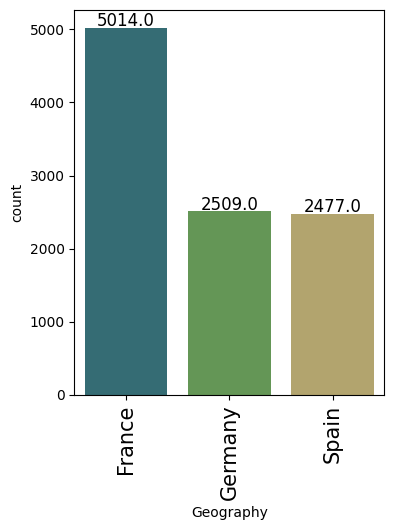

In [28]:
label_bar(df, 'Geography')

- Slightly over half of the customers are from France.
- The other half are split almost evenly between Germany and Spain.

###Gender

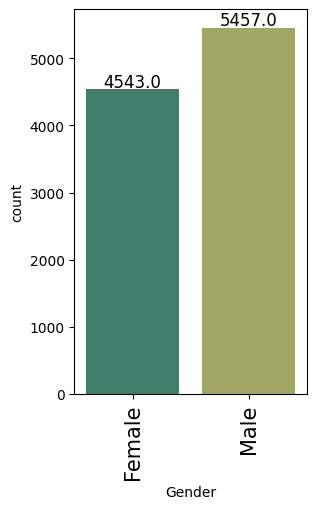

In [29]:
label_bar(df, 'Gender')

- There are more male customers than female, but overall not a significant difference in our dataset.

###Exited Proportions

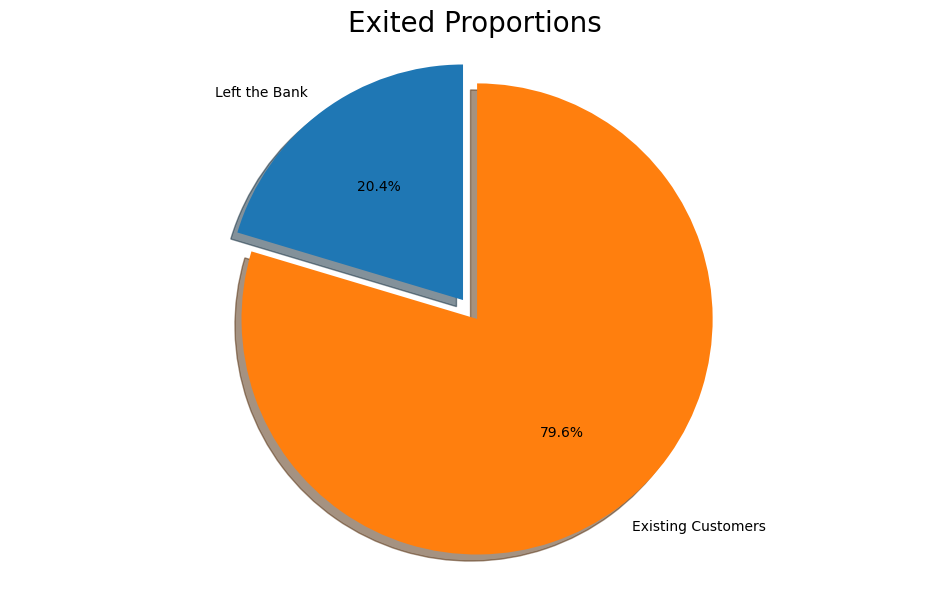

In [30]:
# function to create a pie chart showing proportions for our target variable, 'Exited'
labels = 'Left the Bank', 'Existing Customers'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Exited Proportions', size=20)
plt.show()

- This pie chart helps to better visualize how imbalanced the classes are for our target variable, 'Exited'.
- Only about 20% of the customers in our dataset have left the bank

#Bivariate Analysis

In [31]:
# Function to plot distribution and boxplot of features as compared to our taget variable, 'Exited'

def dist_plot_with_exited(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12,8))

    target_uniq = df[target].unique()

    axs[0, 0].set_title("Distribution for Customers who Exited: ['Exited'] = " + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color='Blue'
    )

    axs[0, 1].set_title("Distribution for Existing Customers: ['Exited'] = " + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color='Orange'
    )

    axs[1, 0].set_title("Boxplot w.r.t. ['Exited']")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1,0], palette='gist_rainbow')

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t. ['Exited']")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette='gist_rainbow',
    )

    plt.tight_layout()
    plt.show()

###Credit Score vs. Exited

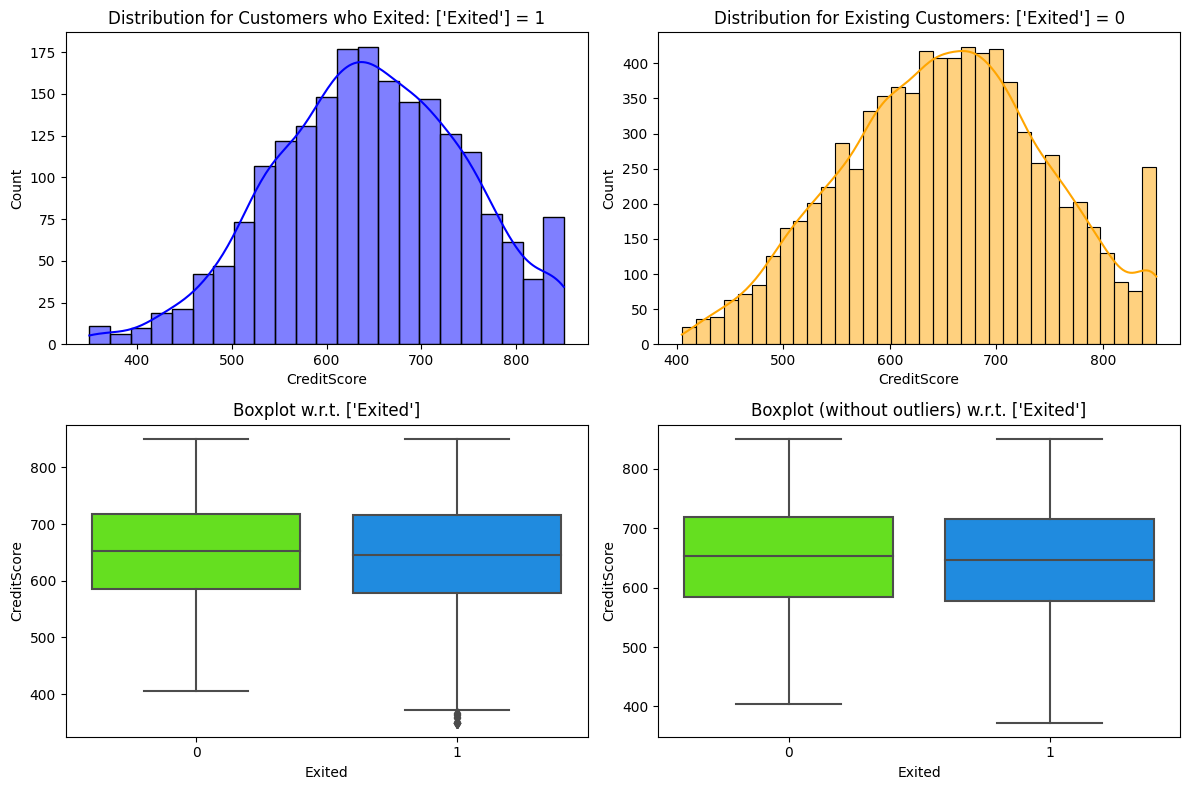

In [32]:
dist_plot_with_exited(df, 'CreditScore', 'Exited')

- The distributions for both existing customers and those who left is fairly similar with respect to credit score.  Both are slightly left skewed, and both show a steady decrease in customers past the mid 600s in credit score, with a larger spike at he max value of 850. Both are comparable to the combined distribution we saw earlier in our univariate analysis.
- One bigger difference is that only those who left the bank have outliers on the low end with respect to credit score. It seems less than 400 is considered an outlier, while there are no existing customers with less than a 400 credit score.

###Age vs. Exited

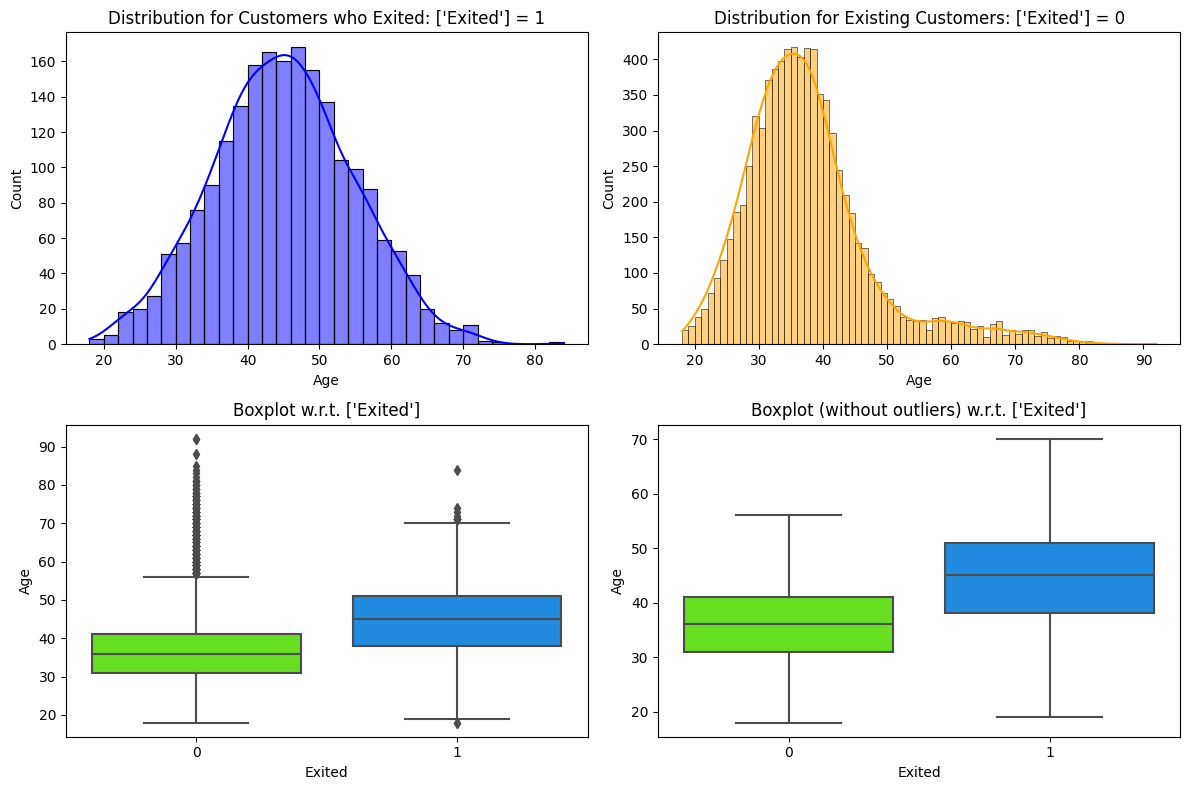

In [33]:
dist_plot_with_exited(df, 'Age', 'Exited')

- Customers who exited have a fairly normal distribution when it comes to Age. There are outliers on both the low and high ends.
- Existing Customers have a much more right skewed distribution. The age range of 60 and above are considered outliers for existing customers. 
- The distribution of existing customers is shifted more towards a younger age range as compared to those who left the bank which has a much more even distribution with respect to age range.

###Tenure vs. Exited

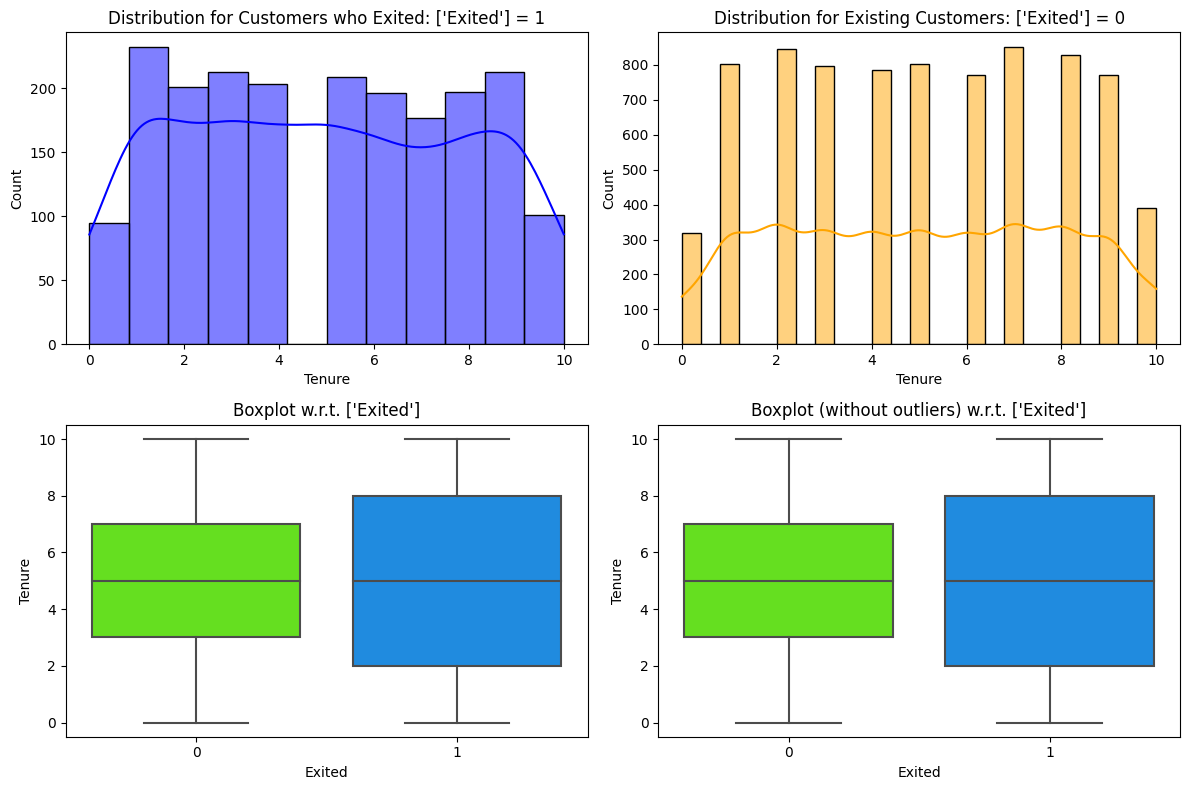

In [34]:
dist_plot_with_exited(df, 'Tenure', 'Exited')

- Not sure that it really says much about whether or not a customer will leave the bank, but the distribution for those that left the bank presents with a farily normal distribution across the different years of tenure except for an odd gap at just over 4 years up to 5 years tenure. It seems no customers left the bank in this tenure range while there are nearly 800 existing customers for this tenure range.
- Distributions for both existing cutomers and those who left show a similar drop off at the mininum tenure of 0 years and the maximum tenure of 10 years.

###Number of Products vs. Exited

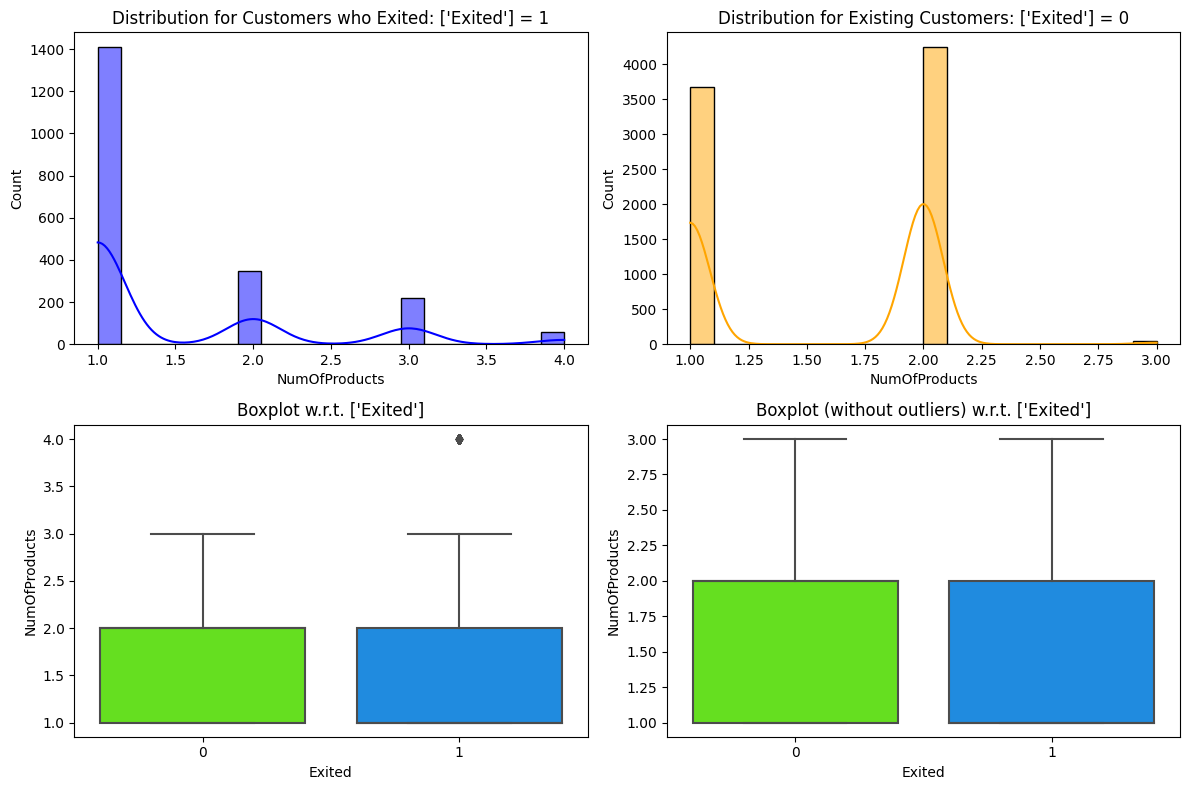

In [35]:
dist_plot_with_exited(df, 'NumOfProducts', 'Exited')

- Surprisingly only those who exited the bank had any customers with 4 bank products, while out of all the existing customers none have 4 bank products and barely any have 3 bank products.
- The number of customers with only 1 bank product is high for both existing customers and those who have left the bank.
- The biggest difference seems to be at those with 2 bank products. 2 products is the highest category for existing customers while a much lower portion of those who left the bank had 2 bank products.

###Balance vs. Exited

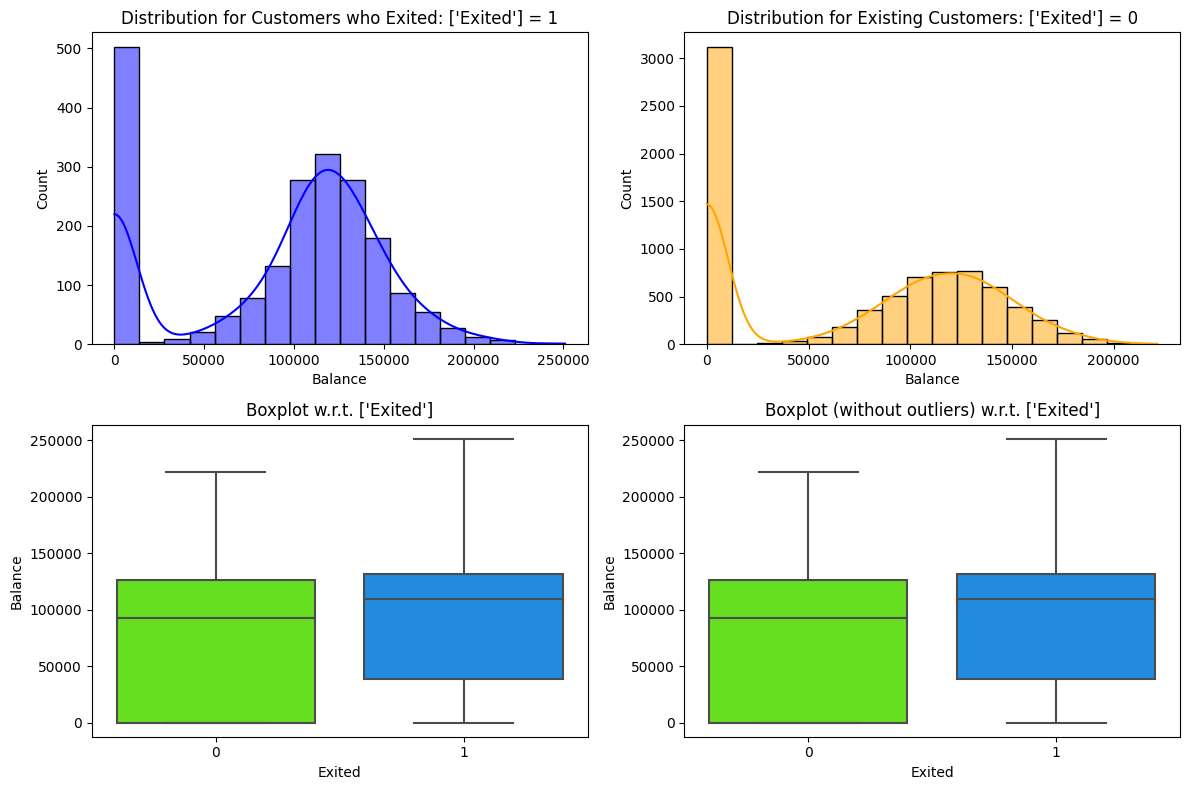

In [36]:
dist_plot_with_exited(df, 'Balance', 'Exited')

- A balance of 0 is the biggest category for both existing customers and those who have left.

###Estimated Salary vs. Exited

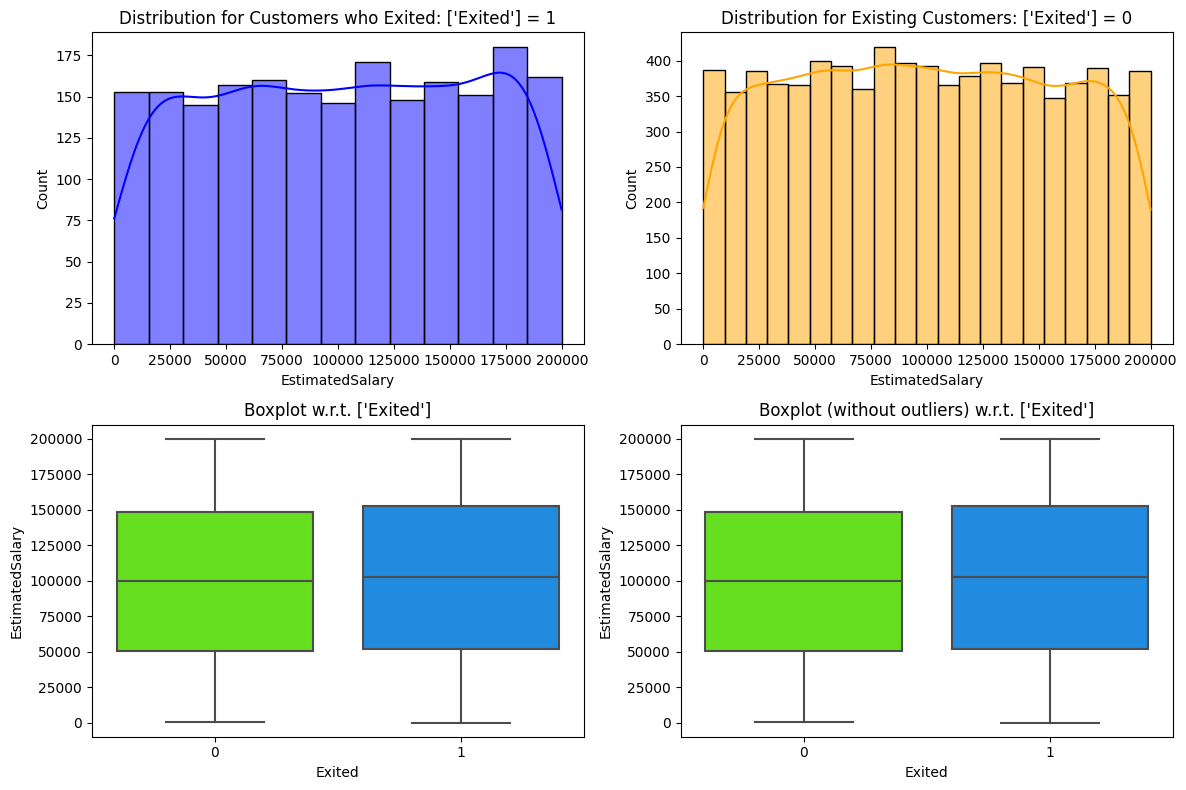

In [37]:
dist_plot_with_exited(df, 'EstimatedSalary', 'Exited')

- Estimated salary is spread fairly evenly along the whole range for both exiting customers and those have left the bank.

###Is Active Member vs. Exited

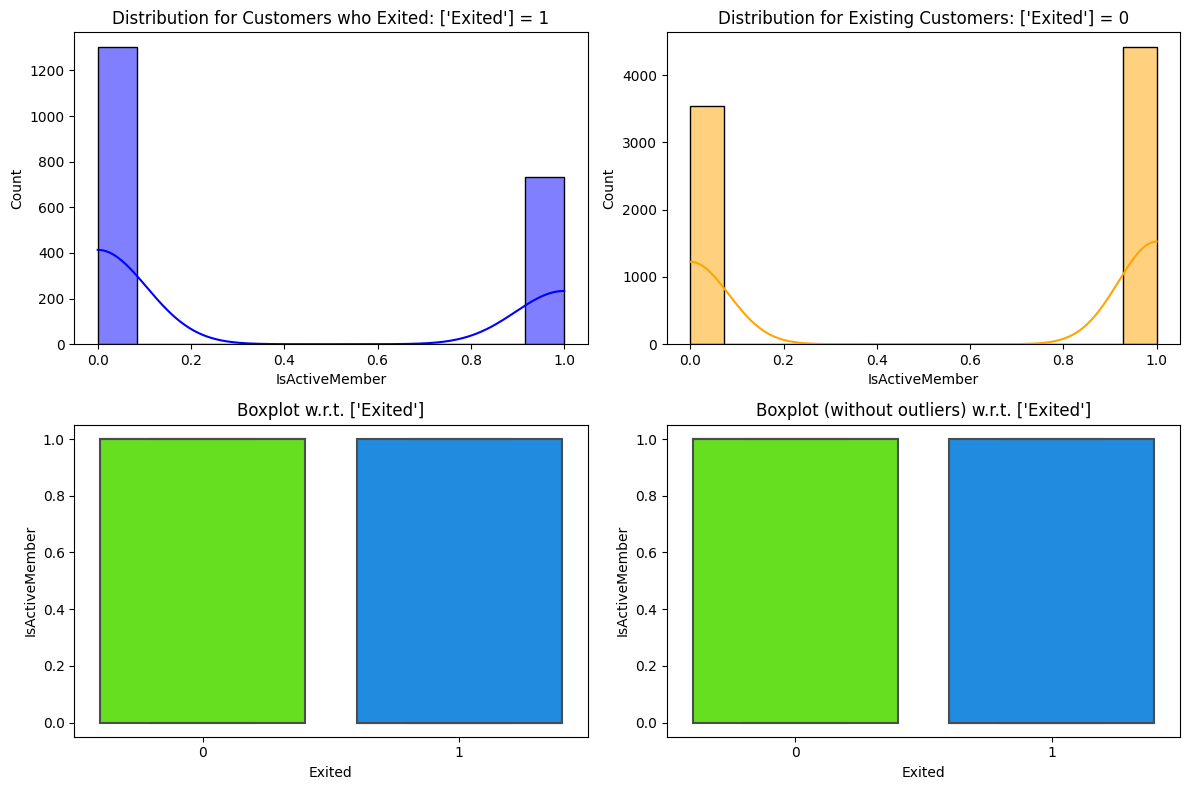

In [38]:
dist_plot_with_exited(df, 'IsActiveMember', 'Exited')

- A greater portion of those who exited the bank were not active members which makes sense.
- While active members are undestandably higher for existing customers the number is not much greater existing but inactive customers. These current but inactive customers could be at a risk of leaving the bank.

In [39]:
# function for stacked barplot

def stacked_bar(data, predictor, target):
    """
    plot stacked bar chart and print category counts

    data: df
    predictor: independent variable
    target: dependent variable ('Exited')
    """

    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print('*'*120)
    tab = pd.crosstab(data[predictor], data[target], normalize='index').sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind='bar', stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc='lower left',
        frameon=False
    )
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

###Geography vs. Exited

Exited        0     1    All
Geography                   
All        7963  2037  10000
Germany    1695   814   2509
France     4204   810   5014
Spain      2064   413   2477
************************************************************************************************************************


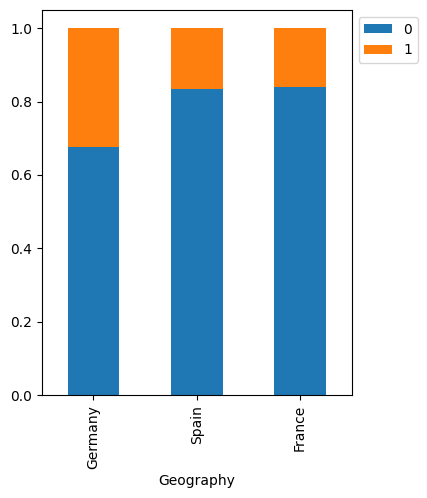

In [40]:
stacked_bar(df, 'Geography', 'Exited')

- France has over half of the customer base, but almost the same amount of customers exiting the bank as Germany, which has the least amount of customers, almost half as many as France.

###Gender vs. Exited

Exited     0     1    All
Gender                   
All     7963  2037  10000
Female  3404  1139   4543
Male    4559   898   5457
************************************************************************************************************************


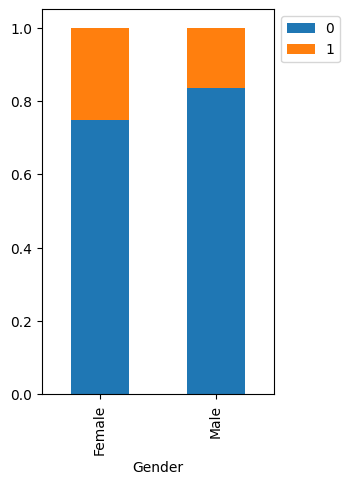

In [41]:
stacked_bar(df, 'Gender', 'Exited')

- There are slightly more males in the overall customer base, yet female customers are exiting the bank at a higher rate.

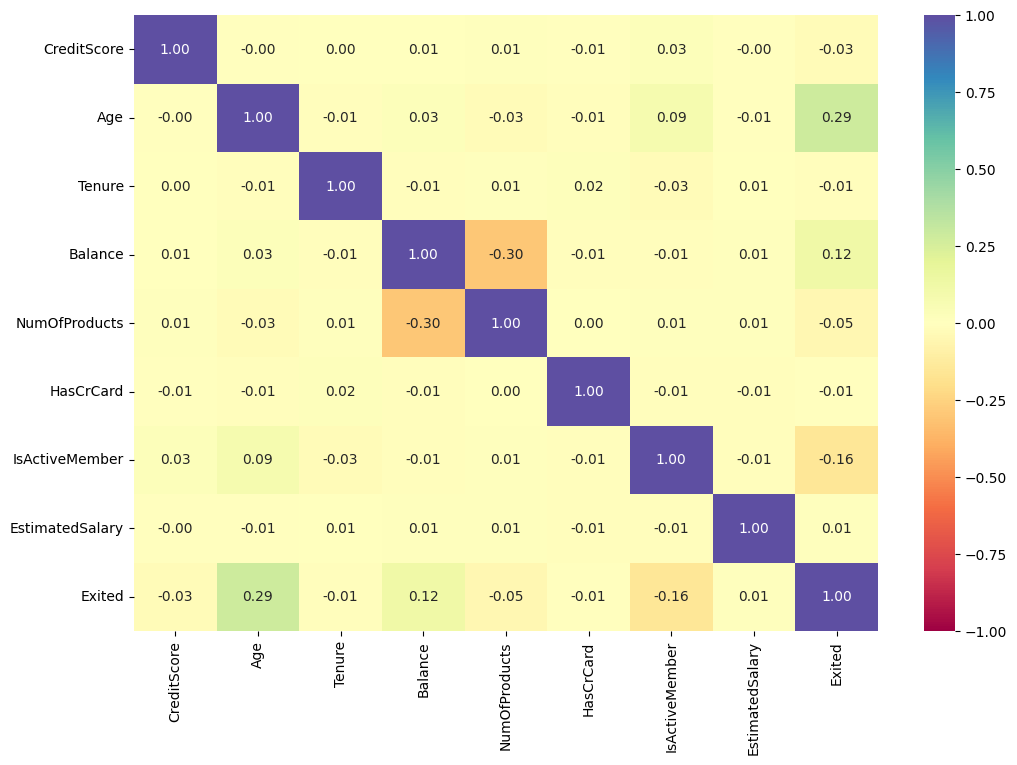

In [42]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

- There does not appear to be any strong correlatin between variables.

#Summary of EDA

- Our dataset has 14 columns, 13 independent variables and 1 dependent variable. We dropped the columns for Row number, Customer Id, and Surname, leaving us 11 with 11 columns, 10 independent features, and 1 target feature.
- Exited is our target variable telling us whether or not a customer has left the bank. The value counts for Exited show that it's highly imbalanced with almost 4x as many customers remaining vs. those who exited. While this is good news for the bank retaining this many of the customers, it is not such great news for our model and its prediction accuracy. We will need to try out some sampling techniques in order to account for this imbalance.
- Nearly half of the customers in this dataset are considered not to be active members with the bank. This must be a concerning statistic to the bank and may be one of the main reasons they are trying to predict whether or not a customer will leave.
- Despite nearly half the customers being considered inactive, less than 1/4 of customers actually left the bank.
- About half of the customers in the dataset are in France, while the other half is split farily close between Germany and Spain. Despite France having twice as many customers as Germany they both have nearly the same amount of customers leaving the bank.
- A small but noteable aspect of credit score showed that no existing customers had less than a 400 credit score. Sub 400 scores were found exclusively amongst those customers who exited.
- There are a total of 4 bank products which customers may have, but almost all existing customers have only 1 or 2 products. Most of the customers with 3 bank products were found amoungst the exiting customers, and those with 4 products were only found in the customer group who left the bank. This is really curious as you would expect those with 3 or 4 products to be more active and invloved with the bank, therefore less likely to leave, yet the data appears to show the opposite being true.
- Gender has a fairly close split amongst the dataset, but there are more male customers than female customers. Despite there being more male customers in the dataset, there are more female customers who are leaving the bank.

#Data Preprocessing

Before we can start on building our models we need to split the data into train and test sets, perform One-hot encoding on our categorical variables, and then scale out data. We need to scale our data before model building with this dataset as there are very large scale differences between our independent variables so scaling them will help our model's predictions to be more accurate.

In [43]:
x = df.drop(['Exited'], axis=1)
y = df[['Exited']]

In [44]:
x.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [45]:
y.head()

,Exited
0,1
1,0
2,1
3,0
4,0


###Splitting Data into Train, Val, and Test sets

In [46]:
x_large, x_test, y_large, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

In [47]:
x_train, x_val, y_train, y_val = train_test_split(x_large, y_large, test_size=0.25, random_state=42, stratify=y_large, shuffle=True) 

In [48]:
print(x_train.shape, x_val.shape, x_test.shape)

(6000, 10) (2000, 10) (2000, 10)


###Categorical Encoding

In [49]:
x_train = pd.get_dummies(x_train,columns = ['Geography', 'Gender'], drop_first =True)
x_test = pd.get_dummies(x_test,columns = ['Geography', 'Gender'], drop_first =True)
x_val = pd.get_dummies(x_val, columns = ['Geography', 'Gender'], drop_first=True)

In [50]:
scaler = StandardScaler()
temp = scaler.fit(x_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])
x_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']] = temp.transform(x_train[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])
x_test[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']] = temp.transform(x_test[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])
x_val[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']] = temp.transform(x_val[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']])

In [51]:
x_train.shape

(6000, 11)

#Model Building
###A model can make wrong predictions in the following ways:
- Predicting a customer will leave the bank when they will not.
- Predicting a customer will remain a customer when they will actualy leave the bank.


###Which case is more important?

- Predicting that the customer is not exiting when they are exiting. This might cause a loss for the banks because due to incorrect identification the bank will not be able to take any initiative to retain those customers. Retaining existing customers is always less costly then generating new customers.

###How to reduce this loss?
- To reduce this loss we would want to reduce False Negatives, so we want Recall to be maximized. In other words identifying the True Positives so that the bank can retain their customers.



###Model 1

In [52]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [53]:
# Initializing our neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=11))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [54]:
rec = tf.keras.metrics.Recall()
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy', rec])

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [56]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
188/188 [==============================] - 2s 6ms/step - loss: 0.5247 - accuracy: 0.7882 - recall: 0.0164 - val_loss: 0.4850 - val_accuracy: 0.7965 - val_recall: 0.0000e+00
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4757 - accuracy: 0.7960 - recall: 0.0000e+00 - val_loss: 0.4612 - val_accuracy: 0.7970 - val_recall: 0.0025
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4566 - accuracy: 0.7967 - recall: 0.0082 - val_loss: 0.4468 - val_accuracy: 0.7990 - val_recall: 0.0147
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4444 - accuracy: 0.7983 - recall: 0.0270 - val_loss: 0.4381 - val_accuracy: 0.8050 - val_recall: 0.0639
Epoch 5/100
188/188 [==============================] - 0s 3ms/step - loss: 0.4361 - accuracy: 0.8043 - recall: 0.0760 - val_loss: 0.4329 - val_accuracy: 0.8100 - val_recall: 0.1081
Epoch 6/100
188/188 [==============================] - 0s 3ms/step - loss: 0.4306 - acc

63/63 [==============================] - 0s 2ms/step - loss: 0.3626 - accuracy: 0.8510 - recall: 0.3980


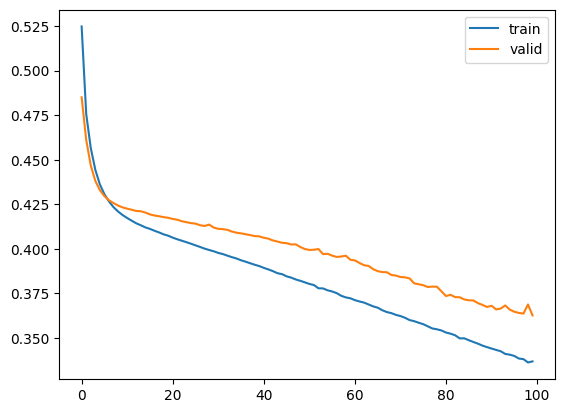

In [57]:
# capturing learning history per epoch
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(('train', 'valid'), loc=0)

# Printing Results
results = model.evaluate(x_val, y_val)

- Validation and training loss are both decreasing but there does seem to be some overfitting. On the plus side there is no noise in the training data.
- our recall could be better so we will try some more models to see if we can improve these metrics.

In [58]:
y_pred=model.predict(x_val)
# creating a threshold of 0.5
y_pred= (y_pred > 0.5)
y_pred

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [59]:
# Creating a function to plot the confusion matrix for our model.

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabel=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Greens',
                          title=None,):

  # text inside each square
  blanks = ['' for i in range(cf.size)]

  if group_names and len(group_names)==cf.size:
      group_labels = ['{}\n'.format(value) for value in group_names]
  else:
    group_labels = blanks

  if count:
      group_counts = ['{0:0.0f}\n'.format(value) for value in cf.flatten()]
  else:
      group_counts = blanks

  if percent:
      group_percentages = ['{0:.2%}'.format(value) for value in cf.flatten()/np.sum(cf)]
  else:
      group_percentages = blanks

  box_labels = [f'{v1}{v2}{v3}'.strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
  box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

  # Code to generate summary stats & text for summary stats
  if sum_stats:
      # Accuracy is sum of diagonal divided by total observations
      accuracy = np.trace(cf) / float(np.sum(cf))

  # Set figure parameters according to other arguments
  if figsize==None:
      # get default figure size if not set
      figsize = plt.rcParams.get('figure.figsize')

  if xyticks==False:
      # Do not show categories if xyticks is False
      categories=False

  # Make the heatmap
  plt.figure(figsize=figsize)
  sns.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

  if title:
      plt.title(title)

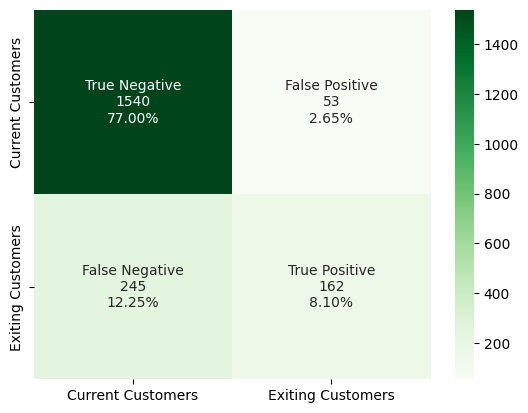

In [60]:
# generating confusion matrix
cm=confusion_matrix(y_val, y_pred)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

In [61]:
# Generate classification report
cr=metrics.classification_report(y_val, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.75      0.40      0.52       407

    accuracy                           0.85      2000
   macro avg       0.81      0.68      0.72      2000
weighted avg       0.84      0.85      0.83      2000



- From the confusion matrix we can see the model has performed well on accuracy and precision but not so great on recall. There could be two reasons why this may be happening.

  1. Imbalanced Dataset, as most of our data belongs to the non_exited class(0).

  2. Decision Threshold, since the dataset is imbalanced we can use ROC-AUC to find the optimal threshold.

We can try tuning the decision threshold as well as applying SMOTE to better balance the dataset.

###Model 2
- For model 2 we will try changing the optimizer from SGD to Adam

In [62]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [63]:
# Initializing our ANN model with dropout, more neurons, and more layers
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

- We can also try adjusting our learning rate to see if that improves things as well

In [64]:
adam=tf.keras.optimizers.Adam(0.001)
model2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', rec])

In [65]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


- We can see here that we have the same number of parameters, 2,881 as we had in our 1st model, the only thing we have changed is the optimizer.

- We will also keep the amount of epochs at 100 so that everything remains the same as model 1, in order to see the effects from just using Adam as our optimizer as opposed to SGD.

In [66]:
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
188/188 [==============================] - 2s 5ms/step - loss: 0.4554 - accuracy: 0.8022 - recall: 0.1791 - val_loss: 0.4252 - val_accuracy: 0.8210 - val_recall: 0.2457
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4158 - accuracy: 0.8215 - recall: 0.2486 - val_loss: 0.4185 - val_accuracy: 0.8250 - val_recall: 0.2875
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.4050 - accuracy: 0.8272 - recall: 0.2895 - val_loss: 0.4120 - val_accuracy: 0.8310 - val_recall: 0.3047
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 0.3976 - accuracy: 0.8310 - recall: 0.3132 - val_loss: 0.4063 - val_accuracy: 0.8385 - val_recall: 0.3489
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.3885 - accuracy: 0.8350 - recall: 0.3483 - val_loss: 0.3985 - val_accuracy: 0.8370 - val_recall: 0.3759
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 0.3804 - accuracy: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.4058 - accuracy: 0.8475 - recall: 0.4742


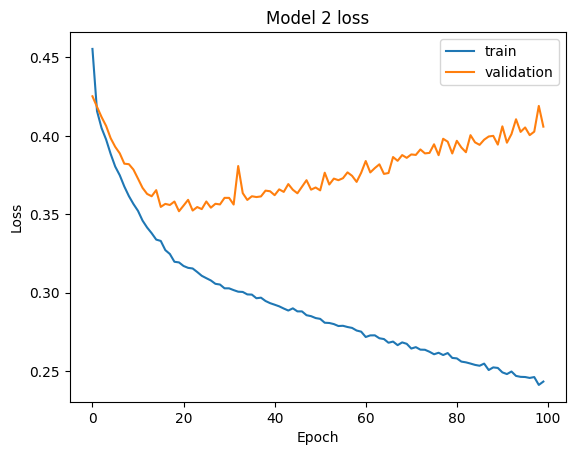

In [67]:
# capturing learning history per epoch
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch

# Plotting accuracy at different epochs
plt.title('Model 2 loss')
plt.plot(hist2['loss'])
plt.plot(hist2['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('train', 'validation'), loc=0)

# Printing Results
results2 = model2.evaluate(x_val, y_val)

- Our model is greatly overfitting and looks to be diverging around epoch 20 so we are going to look at adding Early Stopping to our next model.

###Model 3
- Since our models have been diverging we will try to find the optimal stopping point for model 3 by using Early Stopping.
- By using Early Stopping if the validation shows no improvements for a certain amount of epochs then training is stopped. This stopping point is known to have good generalized performance.

In [68]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [69]:
# Initializing our ANN model3 with batch normilizationt, and adjustments to the number of neurons and layers
model3 = Sequential()
model3.add(Dense(64, activation='relu', input_dim=x_train.shape[1]))
model3.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dense(1, activation='sigmoid'))

In [70]:
adam=tf.keras.optimizers.Adam(0.001)
model3.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', rec])

In [71]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


- sticking with the same model build we will now add early stopping as a callback.

In [72]:
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
history3 = model3.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[es_cb])

Epoch 1/100
188/188 [==============================] - 2s 4ms/step - loss: 0.4547 - accuracy: 0.8023 - recall: 0.2000 - val_loss: 0.4251 - val_accuracy: 0.8210 - val_recall: 0.2334
Epoch 2/100
188/188 [==============================] - 0s 3ms/step - loss: 0.4144 - accuracy: 0.8220 - recall: 0.2518 - val_loss: 0.4171 - val_accuracy: 0.8295 - val_recall: 0.3096
Epoch 3/100
188/188 [==============================] - 0s 3ms/step - loss: 0.4031 - accuracy: 0.8290 - recall: 0.3001 - val_loss: 0.4102 - val_accuracy: 0.8295 - val_recall: 0.3047
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 0.3958 - accuracy: 0.8313 - recall: 0.3181 - val_loss: 0.4043 - val_accuracy: 0.8390 - val_recall: 0.3514
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.3873 - accuracy: 0.8355 - recall: 0.3500 - val_loss: 0.3975 - val_accuracy: 0.8375 - val_recall: 0.3808
Epoch 6/100
188/188 [==============================] - 0s 3ms/step - loss: 0.3794 - accuracy: 0

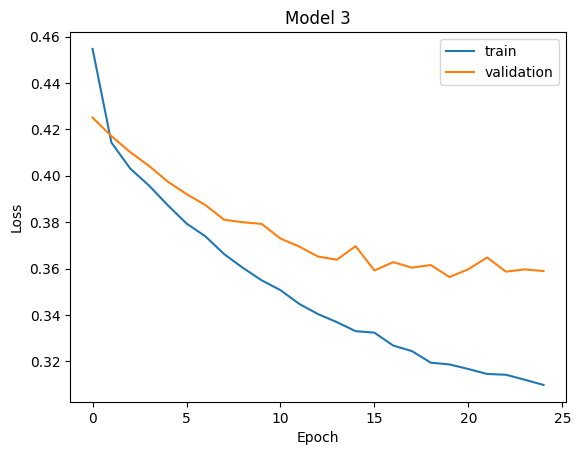

63/63 [==============================] - 0s 1ms/step - loss: 0.3589 - accuracy: 0.8535 - recall: 0.5061


In [73]:
# capturing learning history per epoch
hist3 = pd.DataFrame(history3.history)
hist3['epoch'] = history3.epoch

# Plotting accuracy at different epochs
plt.plot(hist3['loss'])
plt.plot(hist3['val_loss'])
plt.legend(('train', 'validation'), loc=0)
plt.title('Model 3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Printing Results
results3 = model3.evaluate(x_val, y_val)

- As we can see here training stopped at the appropriate epoch as the loss function was starting to increase. Early Stopping has helped to prevent further overfitting.

###Tuning the threshold using ROC-AUC

188/188 [==============================] - 0s 1ms/step
Best Threshold=0.211920, G-mean=0.808


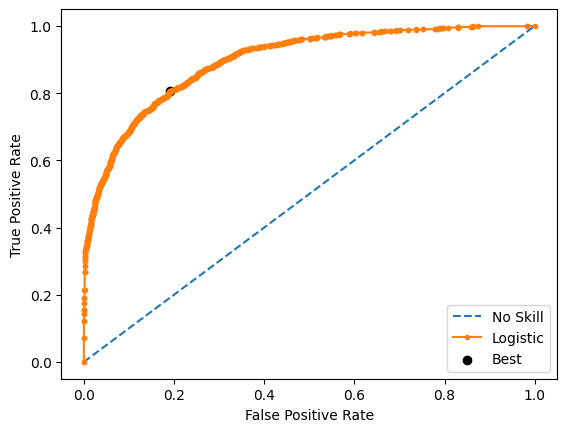

In [74]:
# predict probabilities
yhat=model3.predict(x_train)
# keep probabilities for the positive outcome only
yhat=yhat[:, 0]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

- It shows our best threshold as being 0.21 instead of the 0.5 threshold we have been using.

In [75]:
y_pred_roc=model3.predict(x_val)
y_pred_roc = (y_pred_roc > thresholds[ix])
y_pred_roc

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [False]])

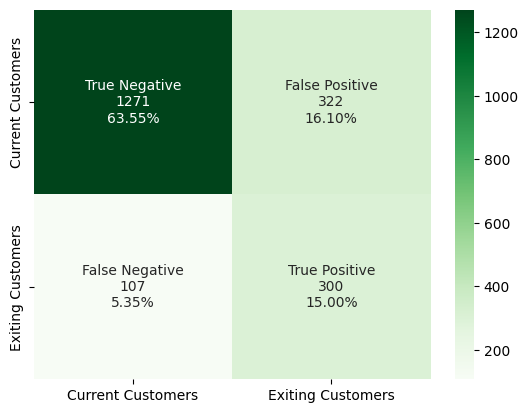

In [76]:
# generating confusion matrix
cm=confusion_matrix(y_val, y_pred_roc)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

In [77]:
# Generate classification report
cr3=metrics.classification_report(y_val, y_pred_roc)
print(cr3)

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.48      0.74      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.77      0.72      2000
weighted avg       0.83      0.79      0.80      2000



- We are doing much better on our 1 class recall at 0.74, and accuracy at 0.79, but our precison and F1 are lower. In this case it is ok since we are trying to maximize recall for the 1 class to better identify customers who might leave.
- I believe we can still improve on this as we are still having some overfitting.

###Model 4
- For this fourth model we will simplify the amount of neurons while adding some dropout layers as well to see if that improves our overfitting.

In [78]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [79]:
model_4 = Sequential()
model_4.add(Dense(32, activation='relu', input_dim=x_train.shape[1]))
model_4.add(Dropout(0.2))
model_4.add(Dense(16, activation='relu'))
model_4.add(Dropout(0.1))
model_4.add(Dense(8, activation='relu'))
model_4.add(Dense(1, activation='sigmoid'))

In [80]:
model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainabl

- We now have less parameters than our previous models and have also added 2 dropout layers,

In [81]:
optimizer = tf.keras.optimizers.Adam(0.001)
model_4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', rec])

In [82]:
history_4 = model_4.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[es_cb])

Epoch 1/100
188/188 [==============================] - 3s 6ms/step - loss: 0.6869 - accuracy: 0.6532 - recall: 0.3491 - val_loss: 0.6370 - val_accuracy: 0.7965 - val_recall: 0.0000e+00
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.5342 - accuracy: 0.7962 - recall: 0.0000e+00 - val_loss: 0.4608 - val_accuracy: 0.7965 - val_recall: 0.0000e+00
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4531 - accuracy: 0.7960 - recall: 8.1766e-04 - val_loss: 0.4399 - val_accuracy: 0.7970 - val_recall: 0.0049
Epoch 4/100
188/188 [==============================] - 0s 3ms/step - loss: 0.4376 - accuracy: 0.7992 - recall: 0.0392 - val_loss: 0.4337 - val_accuracy: 0.7990 - val_recall: 0.0541
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4351 - accuracy: 0.8037 - recall: 0.1169 - val_loss: 0.4278 - val_accuracy: 0.8080 - val_recall: 0.1523
Epoch 6/100
188/188 [==============================] - 0s 3ms/step - loss: 0.42

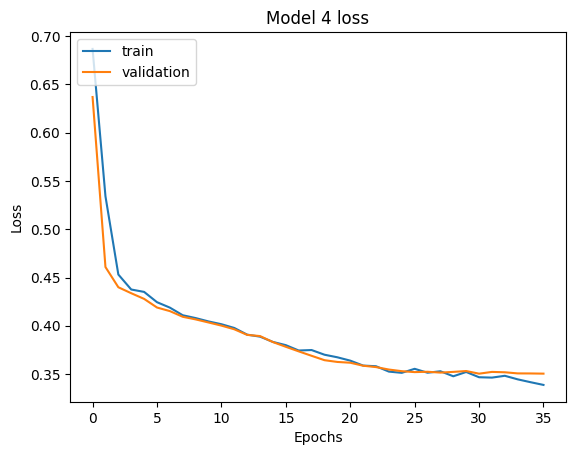

In [83]:
plt.plot(history_4.history['loss'])
plt.plot(history_4.history['val_loss'])
plt.title('Model 4 loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

- We can see here that we are no longer overfitting, so simplifying our model and adding dropout layers has fixed this issue.

188/188 [==============================] - 0s 1ms/step
Best Threshold=0.190838, G-mean=0.795


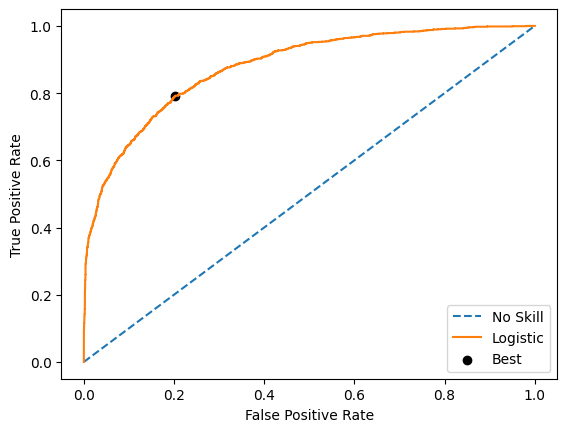

In [84]:
yhat = model_4.predict(x_train)
yhat = yhat[:, 0]
fpr, tpr, thresholds = roc_curve(y_train, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker=',', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [85]:
y_pred = model_4.predict(x_val)
y_pred2 = (y_pred > thresholds[ix])
y_pred2

63/63 [==============================] - 0s 1ms/step


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [86]:
cr4=metrics.classification_report(y_val, y_pred2)
print(cr4)

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1593
           1       0.48      0.78      0.59       407

    accuracy                           0.78      2000
   macro avg       0.71      0.78      0.72      2000
weighted avg       0.84      0.78      0.80      2000



It looks like our recall and accuracy each went down by 1, while our precision and F1 remained the same.

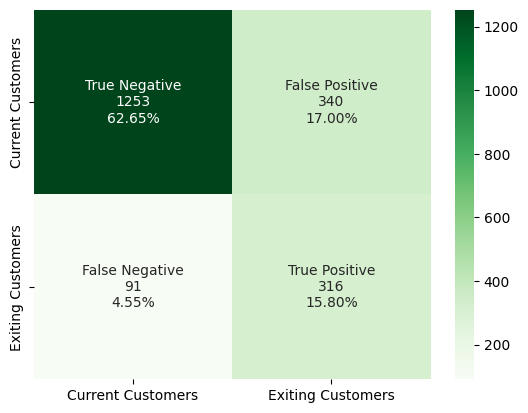

In [87]:
# generating confusion matrix
cm=confusion_matrix(y_val, y_pred2)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

- We can see that our False Negatives have decreased but we are still seeing a fair amount of False Positives.
- Let's see if we can improve things further by using some hyperparameter tuning using GridSearchCV.

###Model for Hyperparameter tuning

In [96]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [97]:
def create_model_cv(dropout_rate=0.5, lr=0.001, layer_1=64, layer_2=32):
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(layer_1, activation='relu', input_dim=x_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

##GridSearchCV

In [98]:
keras_estimator = KerasClassifier(build_fn=create_model_cv, verbose=1)

In [99]:
param_grid = {
    'batch_size':[40, 64, 128],
    'lr':[0.01, 0.001, 0.1]
}

kfold_splits = 3

grid = GridSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_grid=param_grid, n_jobs=-1)

In [100]:
grid_result = grid.fit(x_train, y_train, validation_data = (x_val, y_val), verbose=1)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']

stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
94/94 [==============================] - 1s 5ms/step - loss: 0.4552 - accuracy: 0.8032 - val_loss: 0.4305 - val_accuracy: 0.8190
Best: 0.810833 using {'batch_size': 64, 'lr': 0.01}


- from the grid search we can see that the best batch size is 64 and the best learning rate is 0.01

In [93]:
estimator_cv = create_model_cv(lr=grid_result.best_params_['lr'])
estimator_cv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                768       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


In [94]:
history_cv = estimator_cv.fit(x_train, 
                              y_train, 
                              validation_data=(x_val, y_val), 
                              epochs=100, 
                              batch_size=grid_result.best_params_['batch_size'], 
                              verbose=1,
                              callbacks=[es_cb])

Epoch 1/100
150/150 [==============================] - 2s 6ms/step - loss: 0.4528 - accuracy: 0.8055 - val_loss: 0.4244 - val_accuracy: 0.8160
Epoch 2/100
150/150 [==============================] - 1s 4ms/step - loss: 0.4249 - accuracy: 0.8197 - val_loss: 0.4120 - val_accuracy: 0.8300
Epoch 3/100
150/150 [==============================] - 1s 4ms/step - loss: 0.4143 - accuracy: 0.8260 - val_loss: 0.4029 - val_accuracy: 0.8350
Epoch 4/100
150/150 [==============================] - 1s 4ms/step - loss: 0.4084 - accuracy: 0.8310 - val_loss: 0.3947 - val_accuracy: 0.8400
Epoch 5/100
150/150 [==============================] - 1s 4ms/step - loss: 0.4001 - accuracy: 0.8355 - val_loss: 0.3883 - val_accuracy: 0.8400
Epoch 6/100
150/150 [==============================] - 1s 4ms/step - loss: 0.3937 - accuracy: 0.8433 - val_loss: 0.3794 - val_accuracy: 0.8440
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: 0.3873 - accuracy: 0.8380 - val_loss: 0.3854 - val_accuracy: 0.8445

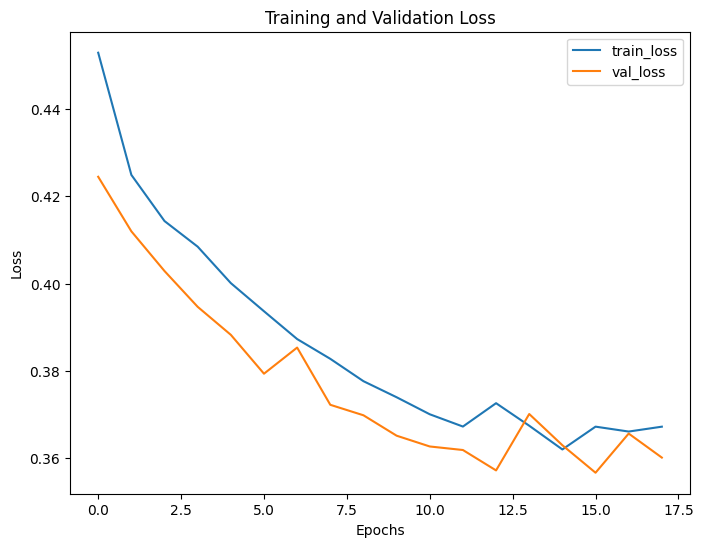

In [102]:
N=18
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,N), history_cv.history['loss'], label='train_loss')
plt.plot(np.arange(0,N), history_cv.history['val_loss'], label='val_loss')

plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.show()

- The validation curve does not have a high slope which means it has not decreased much. Let's check some other metrics.

###Tuning the Threshold

188/188 [==============================] - 0s 1ms/step
Best Threshold=0.201195, G-Mean=0.779


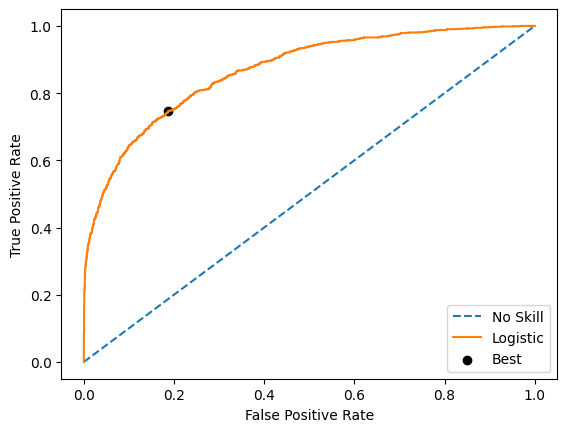

In [103]:
yhat = estimator_cv.predict(x_train)
yhat = yhat[:,0]
fpr, tpr, thresholds = roc_curve(y_train, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker=',', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

- Looks like the best threshold is 0.20
- Let's try predicting the results using this threshold.

In [104]:
y_pred_cv = estimator_cv.predict(x_val)
print(y_pred_cv)

63/63 [==============================] - 0s 2ms/step
[[0.04657876]
 [0.06177078]
 [0.31050807]
 ...
 [0.01187599]
 [0.06356697]
 [0.31563994]]


In [105]:
y_pred_cv = (y_pred_cv > thresholds[ix])
print(y_pred_cv)

[[False]
 [False]
 [ True]
 ...
 [False]
 [False]
 [ True]]


In [106]:
cr5=metrics.classification_report(y_val, y_pred_cv)
print(cr5)

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1593
           1       0.50      0.73      0.59       407

    accuracy                           0.79      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.84      0.79      0.81      2000



- recall is higher at 77 and it is the same for both classes.

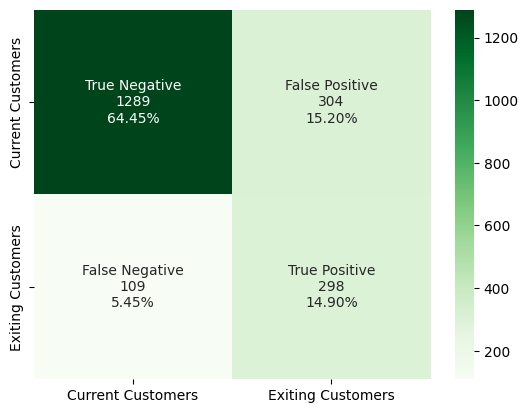

In [107]:
# generating confusion matrix
cm=confusion_matrix(y_val, y_pred_cv)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

- Our False Negatives are looking good but we can still try and do better since False Positive are still showing higher then we'd like.

###Let's try applying SMOTE to balance the dataset.

In [108]:
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)
print('After upsampling x_train shape is: {}'.format(x_train.shape))
print('After upsampling y_train shape is: {}'.format(y_train.shape))

After upsampling x_train shape is: (9554, 11)
After upsampling y_train shape is: (9554, 1)


In [111]:
y_train.value_counts()

Exited
0         4777
1         4777
dtype: int64

- We now have an even 50/50 split for Exited in our training data.
- Now let's create a new model with the balanced dataset.
- We will also make sure to include dropout layers to help prevent overfitting as we saw earlier.

In [129]:
backend.clear_session()
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [130]:
model_5 = Sequential()
model_5.add(Dense(32, activation='relu', input_dim = x_train.shape[1]))
model_5.add(Dropout(0.2))
model_5.add(Dense(16, activation='relu'))
model_5.add(Dropout(0.1))
model_5.add(Dense(8, activation='relu'))
model_5.add(Dense(1, activation='sigmoid'))

In [131]:
model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainabl

In [132]:
optimizer=tf.keras.optimizers.Adam(0.001)

model_5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', rec])

In [133]:
history_5 = model_5.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(x_val, y_val), callbacks=es_cb)

Epoch 1/100
150/150 [==============================] - 2s 5ms/step - loss: 0.6424 - accuracy: 0.6309 - recall: 0.6532 - val_loss: 0.5696 - val_accuracy: 0.6875 - val_recall: 0.6290
Epoch 2/100
150/150 [==============================] - 0s 3ms/step - loss: 0.5699 - accuracy: 0.7170 - recall: 0.7318 - val_loss: 0.5616 - val_accuracy: 0.7160 - val_recall: 0.6806
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.5527 - accuracy: 0.7304 - recall: 0.7429 - val_loss: 0.5611 - val_accuracy: 0.7185 - val_recall: 0.6880
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.5418 - accuracy: 0.7344 - recall: 0.7496 - val_loss: 0.5472 - val_accuracy: 0.7230 - val_recall: 0.6708
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: 0.5302 - accuracy: 0.7409 - recall: 0.7534 - val_loss: 0.5479 - val_accuracy: 0.7160 - val_recall: 0.6781
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: 0.5236 - accuracy: 0

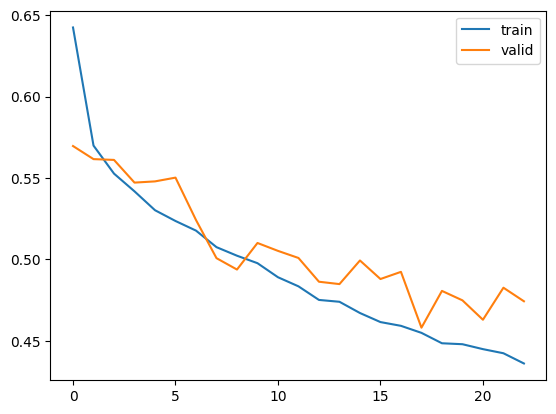

In [134]:
hist5 = pd.DataFrame(history_5.history)
plt.plot(hist5['loss'])
plt.plot(hist5['val_loss'])
plt.legend(('train', 'valid'), loc=0)

###Finding the optimal threshold

299/299 [==============================] - 1s 4ms/step
Best Threshold=0.517189, G-Mean=0.820


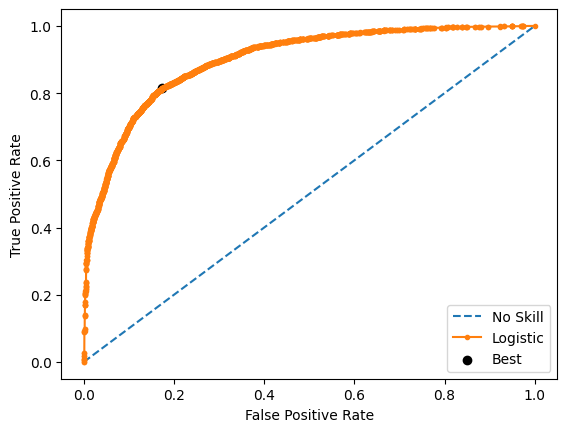

In [137]:
y_hat = model_5.predict(x_train)
y_hat = y_hat[:, 0]
fpr, tpr, thresholds = roc_curve(y_train, y_hat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

- Since our dataset is now balanced our threshold is closer to 0.5

In [138]:
y_pred_5 = model_5.predict(x_val)
y_pred_5 = (y_pred_5 > thresholds[ix])
y_pred_5

63/63 [==============================] - 0s 2ms/step


array([[False],
       [False],
       [ True],
       ...,
       [False],
       [False],
       [ True]])

In [139]:
cr5=metrics.classification_report(y_val, y_pred_5)
print(cr5)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1593
           1       0.50      0.71      0.59       407

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.83      0.80      0.81      2000



- It looks like SMOTE did not improve upon our previous models.

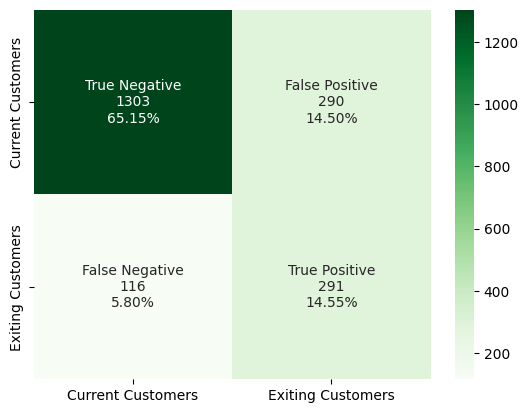

In [140]:
# generating confusion matrix
cm=confusion_matrix(y_val, y_pred_5)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

### Let's try some hyperparameters tuning to see if we can improve our SMOTE model.

In [141]:
backend.clear_session()
np.random.seed(2)
random.seed(2)
tf.random.set_seed(2)

In [143]:
def create_model_v2(dropout_rate=0.1, lr=0.001, layer_1=32, layer_2=16, layer_3=8):
    np.random.seed(1337)
    model = Sequential()
    model.add(Dense(layer_1, activation='relu', input_dim=x_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(layer_3, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

##GridSearchCV
- we will be looking at optimizing 3 parameters with our grid search:
    
      1. batch size
      2. epochs
      3. dropout rate

In [144]:
keras_estimator = KerasClassifier(build_fn=create_model_v2, verbose=1)

In [145]:
param_grid = {
      'batch_size':[40, 64, 128],
      'lr':[0.01, 0.001, 0.1],
      'dropout_rate':[0.1, 0.2, 0.3]
}

kfold_splits = 3
grid = GridSearchCV(estimator=keras_estimator,
                    verbose=1,
                    cv=kfold_splits,
                    param_grid=param_grid,
                    n_jobs=-1)

In [146]:
grid_result = grid.fit(x_train, y_train, validation_split=0.2, verbose=1)

print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 3 folds for each of 27 candidates, totalling 81 fits
120/120 [==============================] - 1s 4ms/step - loss: 0.5567 - accuracy: 0.7026 - val_loss: 0.6306 - val_accuracy: 0.7070
Best: 0.595954 using {'batch_size': 64, 'dropout_rate': 0.1, 'lr': 0.01}


- It looks like our best parameters will be a batch_size of 64, with a dropout rate of 0.1, and a lr of 0.01

##Final model

- We will use the hyperparameters from the GridSearchCV to configure our final model.

In [147]:
estimator_v2 = create_model_v2(dropout_rate=grid_result.best_params_['dropout_rate'], lr=grid_result.best_params_['lr'])
estimator_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                384       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-traina

In [148]:
es_cb = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=25)
history_6 = estimator_v2.fit(x_train, 
                             y_train, 
                             epochs=100, 
                             batch_size=grid_result.best_params_['batch_size'], 
                             verbose=1, 
                             validation_split=0.2, 
                             callbacks=[es_cb])

Epoch 1/100
120/120 [==============================] - 4s 10ms/step - loss: 0.5615 - accuracy: 0.7040 - val_loss: 0.5529 - val_accuracy: 0.7017
Epoch 2/100
120/120 [==============================] - 1s 4ms/step - loss: 0.5023 - accuracy: 0.7621 - val_loss: 0.7720 - val_accuracy: 0.5730
Epoch 3/100
120/120 [==============================] - 1s 4ms/step - loss: 0.4872 - accuracy: 0.7665 - val_loss: 0.5284 - val_accuracy: 0.7718
Epoch 4/100
120/120 [==============================] - 0s 3ms/step - loss: 0.4724 - accuracy: 0.7764 - val_loss: 0.5713 - val_accuracy: 0.6923
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: 0.4628 - accuracy: 0.7825 - val_loss: 0.4871 - val_accuracy: 0.7263
Epoch 6/100
120/120 [==============================] - 0s 3ms/step - loss: 0.4584 - accuracy: 0.7823 - val_loss: 0.5426 - val_accuracy: 0.7425
Epoch 7/100
120/120 [==============================] - 0s 3ms/step - loss: 0.4449 - accuracy: 0.7907 - val_loss: 0.5043 - val_accuracy: 0.752

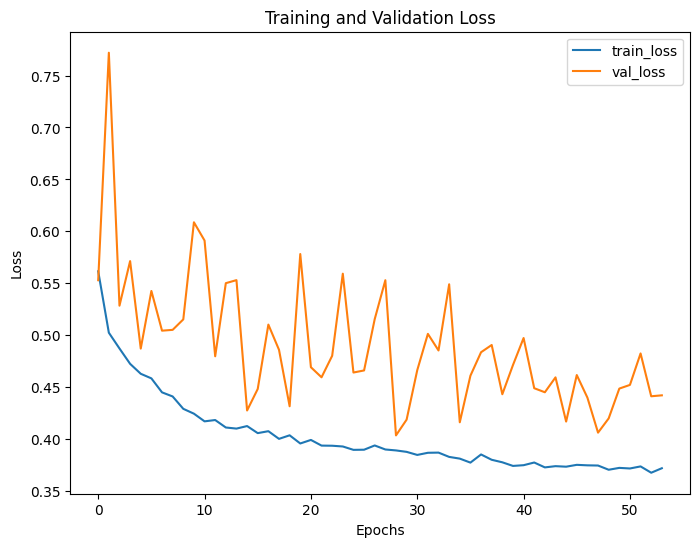

In [150]:
N=54
plt.figure(figsize=(8,6))
plt.plot(np.arange(0,N), history_6.history['loss'], label='train_loss')
plt.plot(np.arange(0,N), history_6.history['val_loss'], label='val_loss')

plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.show()

- This model is definitely not as good as some of our previous models.
- Here we can see quite a bit of overfitting in addition to a great deal of noise in the validation data.

299/299 [==============================] - 1s 4ms/step
Best Threshold=0.375488, G-Mean=0.844


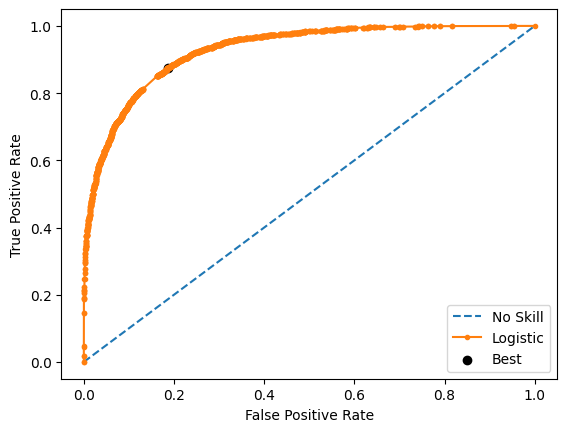

In [151]:
y_hat = estimator_v2.predict(x_train)
y_hat = y_hat[:, 0]
fpr, tpr, thresholds = roc_curve(y_train, y_hat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

###Results using best threshold

In [152]:
y_pred_6 = estimator_v2.predict(x_val)
y_pred_6 = (y_pred_6 > thresholds[ix])
print(y_pred_6)

63/63 [==============================] - 0s 3ms/step
[[False]
 [False]
 [ True]
 ...
 [False]
 [False]
 [ True]]


###Confusion Matrix

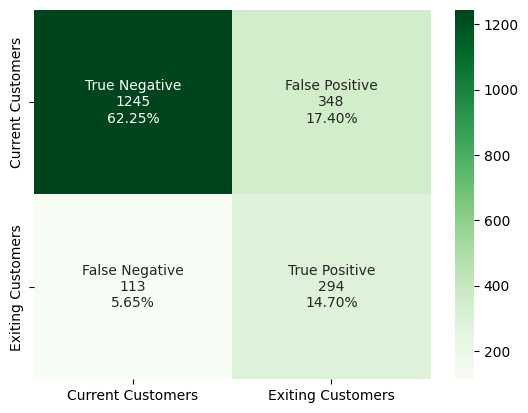

In [153]:
# generating confusion matrix
cm=confusion_matrix(y_val, y_pred_6)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

In [154]:
cr6=metrics.classification_report(y_val, y_pred_6)
print(cr6)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1593
           1       0.46      0.72      0.56       407

    accuracy                           0.77      2000
   macro avg       0.69      0.75      0.70      2000
weighted avg       0.82      0.77      0.79      2000



- These results are not as strong as some of our previous models. It seems using SMOTE and hyperparameter tuning is not a good approach for this particular dataset.
- The best approach was using a more simplified neural network with dropout in order to get the best results, which we saw in model 4.

### Now let's use model 4 to predict on the test data

299/299 [==============================] - 1s 2ms/step
Best Threshold=0.190337, G-Mean=0.810


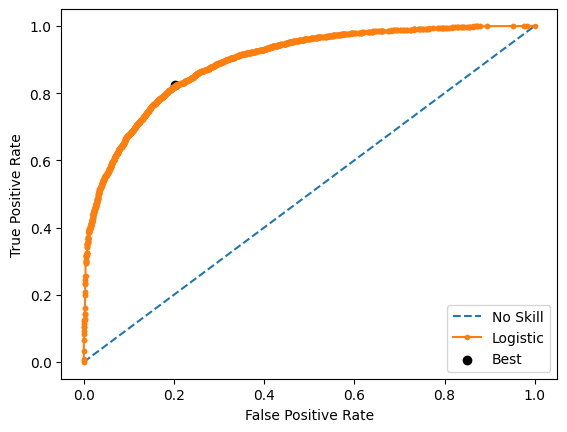

In [155]:
y_hat = model_4.predict(x_train)
y_hat = y_hat[:, 0]
fpr, tpr, thresholds = roc_curve(y_train, y_hat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [156]:
y_pred_test = model_4.predict(x_test)
y_pred_4 = (y_pred_test > thresholds[ix])
print(y_pred_test)

63/63 [==============================] - 1s 8ms/step
[[0.01858273]
 [0.08685798]
 [0.06343264]
 ...
 [0.8101389 ]
 [0.00742863]
 [0.09982489]]


In [157]:
cr_test = metrics.classification_report(y_test, y_pred_4)
print(cr_test)

              precision    recall  f1-score   support

           0       0.93      0.78      0.85      1593
           1       0.48      0.77      0.59       407

    accuracy                           0.78      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.84      0.78      0.80      2000



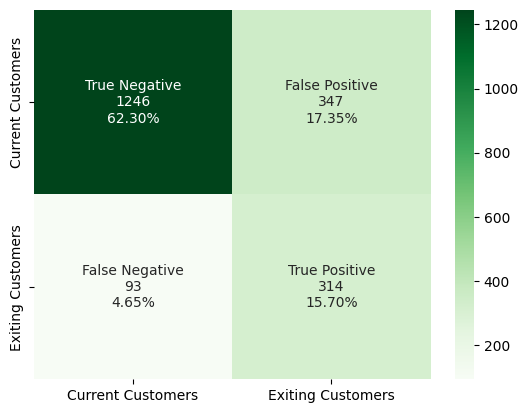

In [158]:
# generating confusion matrix
cm_test=confusion_matrix(y_test, y_pred_4)
labels= ['True Negative', 'False Positive', 'False Negative', 'True Positive']
categories = ['Current Customers', 'Exiting Customers']
make_confusion_matrix(cm_test,
                      group_names=labels,
                      categories=categories,
                      cmap='Greens')

##Conclusion
- Older customers are churning at a higher rate than younger customers, this could possibly be due to differing preferences in service amongst the age categories.
- As far as tenure it seems clients at either end of the spectrum, being those who were with the bank a very short time or a very long time were more likely to churn compared to those in the middle of the tenure spectrum. This is concerning because the bank is losing long time customers who have large balances with the bank.
- Female customers are churning at a greater rate than males.
- Also the majority of the customers who churned were those with credit cards.

##Business Recommendations
- I would reccomend that the bank use model 4, but if they could provide a greater amount of data then they may be able to improve on this model even further.
- They should definitely focus on retaining their long time older customers as they tend to have the larger balances that would be withdrawn when they churn, so these would be the key customers to focus on retaining.
- After this focusing on credit card holders both male and female but the female cutomers may need a different approach to prevent them from churning at a higher rate.